In [1]:
import pandas as pd
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)


In [2]:
user = pd.read_csv('users_clean.csv')#, sep=';', error_bad_lines=False, encoding="latin-1")
user.columns = ['userID', 'Location', 'Age']
rating = pd.read_csv('rating_explicit.csv')#, sep=';', error_bad_lines=False, encoding="latin-1")
rating.columns = ['userID', 'ISBN', 'bookRating']

In [3]:
user.head()

,userID,Location,Age
0,1,"nyc, new york, usa",34
1,2,"stockton, california, usa",18
2,3,"moscow, yukon territory, russia",34
3,4,"porto, v.n.gaia, portugal",17
4,5,"farnborough, hants, united kingdom",34


In [4]:
rating.head()

,userID,ISBN,bookRating
0,276726,0155061224,5
1,276729,052165615X,3
2,276729,0521795028,6
3,276744,038550120X,7
4,276747,0060517794,9


In [5]:
df = pd.merge(user, rating, on='userID', how='inner')
df.drop(['Location', 'Age'], axis=1, inplace=True)

In [6]:
df.head()

,userID,ISBN,bookRating
0,8,0002005018,5
1,8,074322678X,5
2,8,0887841740,5
3,8,1552041778,5
4,8,1567407781,6


In [7]:
df.shape

(383842, 3)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 383842 entries, 0 to 383841
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   userID      383842 non-null  int64 
 1   ISBN        383842 non-null  object
 2   bookRating  383842 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 11.7+ MB


In [9]:
print('Dataset shape: {}'.format(df.shape))
print('-Dataset examples-')
print(df.iloc[::200000, :])

Dataset shape: (383842, 3)
-Dataset examples-
        userID        ISBN  bookRating
0       8       0002005018  5         
200000  139467  006099486X  8         


## EDA

### Ratings Distribution

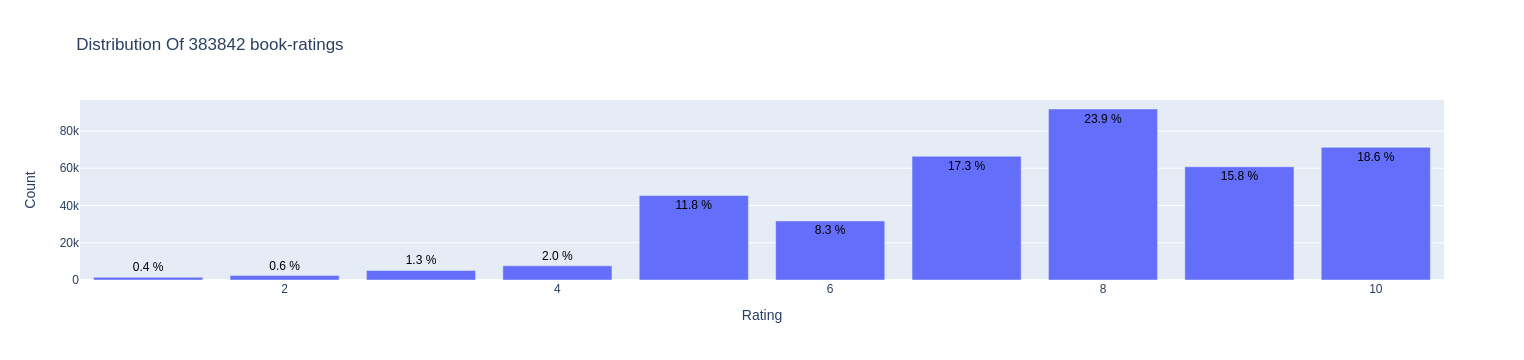

In [10]:
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

data = df['bookRating'].value_counts().sort_index(ascending=False)
trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / df.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values,
               )
# Create layout
layout = dict(title = 'Distribution Of {} book-ratings'.format(df.shape[0]),
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Count'))
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

We can see that over 62% of all ratings in the data are 0, and very few ratings are 1 or 2, or 3, low rating books mean they are generally really bad.

### Ratings Distribution By Book

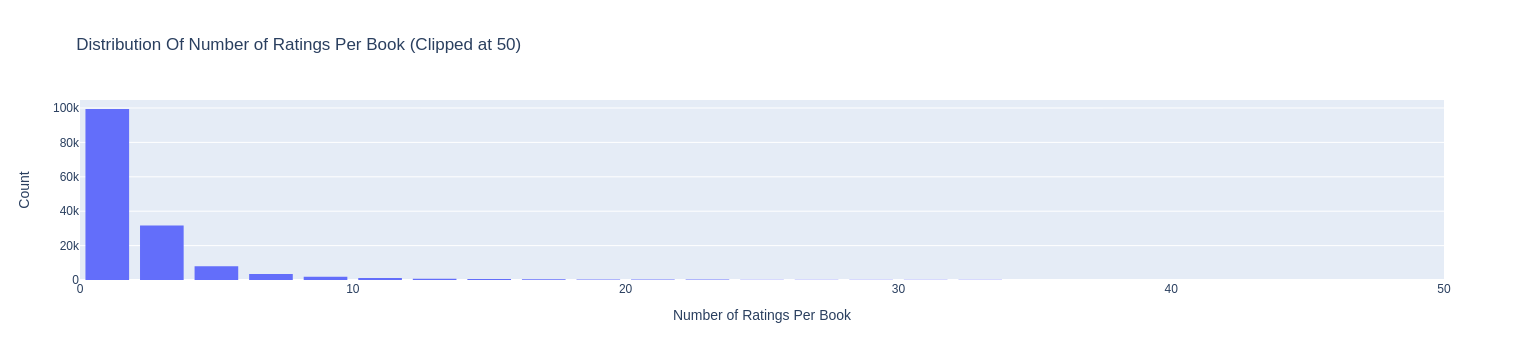

In [11]:
# Number of ratings per book
data = df.groupby('ISBN')['bookRating'].count().clip(upper=50)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per Book (Clipped at 50)',
                   xaxis = dict(title = 'Number of Ratings Per Book'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [12]:
df.groupby('ISBN')['bookRating'].count().reset_index().sort_values('bookRating', ascending=False)[:10]

,ISBN,bookRating
21945,0316666343,707
117745,0971880107,581
38819,0385504209,487
18058,0312195516,383
4131,0060928336,320
68898,059035342X,313
12325,0142001740,307
51799,0446672211,295
47986,044023722X,281
57625,0452282152,278


Most of the books received less than 5 ratings, and very few books have many ratings, although the most rated book has received 2,502 ratings.

### Ratings Distribution By User

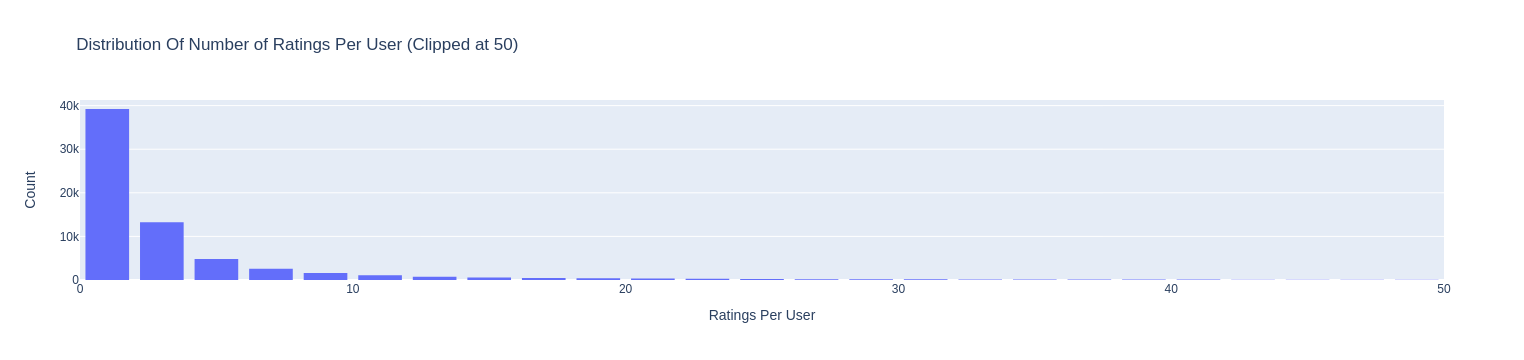

In [13]:
# Number of ratings per user
data = df.groupby('userID')['bookRating'].count().clip(upper=50)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per User (Clipped at 50)',
                   xaxis = dict(title = 'Ratings Per User'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [14]:
df.groupby('userID')['bookRating'].count().reset_index().sort_values('bookRating', ascending=False)[:10]

,userID,bookRating
2719,11676,6943
24101,98391,5691
46279,189835,1899
37648,153662,1845
5615,23902,1180
57320,235105,1020
18757,76499,1012
41781,171118,962
3902,16795,959
60772,248718,941


Most of the users gave less than 5 ratings, and very few users gave many ratings, although the most productive user have given 13,602 ratings.

I'm sure you have noticed that the above two charts share the same distribution. The number of ratings per movie and the number of ratings per user decay exponentially.

To reduce the dimensionality of the dataset, we will filter out rarely rated movies and rarely rating users.

In [15]:
min_book_ratings = 50
filter_books = df['ISBN'].value_counts() > min_book_ratings
filter_books = filter_books[filter_books].index.tolist()

min_user_ratings = 50
filter_users = df['userID'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

df_new = df[(df['ISBN'].isin(filter_books)) & (df['userID'].isin(filter_users))]
print('The original data frame shape:\t{}'.format(df.shape))
print('The new data frame shape:\t{}'.format(df_new.shape))

The original data frame shape:	(383842, 3)
The new data frame shape:	(13137, 3)


## Surprise

To load a dataset from a pandas dataframe, we will use the load_from_df() method, we will also need a Reader object, and the rating_scale parameter must be specified. The dataframe must have three columns, corresponding to the user ids, the item ids, and the ratings in this order. Each row thus corresponds to a given rating.

In [16]:
reader = Reader(rating_scale=(0, 9))
data = Dataset.load_from_df(df_new[['userID', 'ISBN', 'bookRating']], reader)

In [17]:
data

With the Surprise library, we will benchmark the following algorithms

### Basic algorithms

- **NormalPredictor:** NormalPredictor algorithm predicts a random rating based on the distribution of the training set, which is assumed to be normal. This is one of the most basic algorithms that do not do much work.

- **BaselineOnly:** BasiclineOnly algorithm predicts the baseline estimate for given user and item.

### k-NN algorithms

- **KNNBasic:** KNNBasic is a basic collaborative filtering algorithm.

- **KNNWithMeans:** KNNWithMeans is basic collaborative filtering algorithm, taking into account the mean ratings of each user.

- **KNNWithZScore:** KNNWithZScore is a basic collaborative filtering algorithm, taking into account the z-score normalization of each user.

- **KNNBaseline:** KNNBaseline is a basic collaborative filtering algorithm taking into account a baseline rating.

### Matrix Factorization-based algorithms

- **SVD:** SVD algorithm is equivalent to Probabilistic Matrix Factorization (http://papers.nips.cc/paper/3208-probabilistic-matrix-factorization.pdf)

- **SVDpp:** The SVDpp algorithm is an extension of SVD that takes into account implicit ratings.

- **NMF:** NMF is a collaborative filtering algorithm based on Non-negative Matrix Factorization. It is very similar with SVD.

- **Slope One:** Slope One is a straightforward implementation of the SlopeOne algorithm. (https://arxiv.org/abs/cs/0702144)

- **Co-clustering:** Co-clustering is a collaborative filtering algorithm based on co-clustering (http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.113.6458&rep=rep1&type=pdf)


We use rmse as our accuracy metric for the predictions.

In [18]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


In [19]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

surprise_results

,test_rmse,fit_time,test_time
Algorithm,,,
SVDpp,1.545043,1.234533,0.383181
SVD,1.552487,0.194075,0.070867
BaselineOnly,1.560712,0.022262,0.025221
CoClustering,1.635145,0.407078,0.029332
KNNBaseline,1.672940,0.052500,0.249461
KNNWithZScore,1.676097,0.113671,0.234439
KNNWithMeans,1.678979,0.047459,0.258323
SlopeOne,1.756392,0.039269,0.096436
KNNBasic,1.761906,0.032742,0.198644


***SVD++ algorithm gave us one of the best rmse, therefore, we will proceed further with SVD++ with cross validation and prediction***

## SVD
SVD is implemented in the [Surprise](https://surprise.readthedocs.io/en/stable/) library as a recommender module. 
* Detailed documentations of the SVD module in Surprise can be found [here](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD).
* Source codes of the SVD implementation is available on the Surprise Github repository, which can be found [here](https://github.com/NicolasHug/Surprise/blob/master/surprise/prediction_algorithms/matrix_factorization.pyx).
  
The SVD model algorithm is very similar to the ALS algorithm presented in the ALS deep dive notebook. The two differences between the two approaches are:

- SVD additionally models the user and item biases (also called baselines in the litterature) from users and items.
- The optimization technique in ALS is Alternating Least Squares (hence the name), while SVD uses stochastic gradient descent.



In ALS, the ratings are modeled as follows:

$$\hat r_{u,i} = q_{i}^{T}p_{u}$$

SVD introduces two new scalar variables: the user biases $b_u$ and the item biases $b_i$. The user biases are supposed to capture the tendency of some users to rate items higher (or lower) than the average. The same goes for items: some items are usually rated higher than some others. The model is SVD is then as follows:

$$\hat r_{u,i} = \mu + b_u + b_i + q_{i}^{T}p_{u}$$

Where $\mu$ is the global average of all the ratings in the dataset. The regularised optimization problem naturally becomes:

$$ \sum(r_{u,i} - (\mu + b_u + b_i + q_{i}^{T}p_{u}))^2 +     \lambda(b_i^2 + b_u^2 + ||q_i||^2 + ||p_u||^2)$$

where $\lambda$ is a the regularization parameter.

##


**Stochastic Gradient Descent**

Stochastic Gradient Descent (SGD) is a very common algorithm for optimization where the parameters (here the biases and the factor vectors) are iteratively incremented with the negative gradients w.r.t the optimization function. The algorithm essentially performs the following steps for a given number of iterations:


$$b_u \leftarrow b_u + \gamma (e_{ui} - \lambda b_u)$$
$$b_i \leftarrow b_i + \gamma (e_{ui} - \lambda b_i)$$  
$$p_u \leftarrow p_u + \gamma (e_{ui} \cdot q_i - \lambda p_u)$$
$$q_i \leftarrow q_i + \gamma (e_{ui} \cdot p_u - \lambda q_i)$$

where $\gamma$ is the learning rate and $e_{ui} =  r_{ui} - \hat r_{u,i} = r_{u,i} - (\mu + b_u + b_i + q_{i}^{T}p_{u})$ is the error made by the model for the pair $(u, i)$.

## Surprise implementation of SVD++



SVD++ (Matrix Factorization with Bias) is an extension of the Singular Value Decomposition (SVD) algorithm, commonly used in collaborative filtering recommender systems. Let's delve into how it works:
SVD++ incorporates user and item biases into the model:

- User Bias: A user bias vector is added to the predicted rating based on SVD. This vector represents the user's tendency to rate items higher or lower on average compared to the global rating scale.
- Item Bias: An item bias vector is added to the predicted rating. This vector captures the inherent popularity or unpopularity of an item relative to the average rating across all users.

By incorporating these biases, SVD++ can provide more accurate rating predictions by considering not only the compatibility between user preferences and item characteristics (captured by latent factors) but also the systematic rating offsets specific to users and items.

Benefits of SVD++:

- Improved Accuracy: By accounting for user and item biases, SVD++ can lead to more accurate rating predictions compared to traditional SVD.
- Interpretability: The user and item latent factors can still provide insights into user preferences and item characteristics, even with the addition of bias terms.

#### **SVDpp Parameters**

>### *classsurprise.prediction_algorithms.matrix_factorization.SVDpp(n_factors=20, n_epochs=20, init_mean=0, init_std_dev=0.1, lr_all=0.007, reg_all=0.02, lr_bu=None, lr_bi=None, lr_pu=None, lr_qi=None, lr_yj=None, reg_bu=None, reg_bi=None, reg_pu=None, reg_qi=None, reg_yj=None, random_state=None, verbose=False, cache_ratings=False)*

to understand parameters refer to surprise document: https://surprise.readthedocs.io/en/stable/matrix_factorization.html

**GridSearchCV**

In [21]:
from surprise import Dataset, SVD
from surprise.model_selection import GridSearchCV


param_grid = {"n_factors": [20, 30], "lr_all": [0.002, 0.005, 0.007], "reg_all": [0.02, 0.1]}
gs = GridSearchCV(SVDpp, param_grid, measures=["rmse", "mae"], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score["rmse"])

# combination of parameters that gave the best RMSE score
print(gs.best_params["rmse"])

1.5380572485382384
{'n_factors': 20, 'lr_all': 0.007, 'reg_all': 0.1}


In [22]:
from surprise.model_selection import cross_validate
from surprise import SVDpp

clf = SVDpp(n_factors= 20, lr_all= 0.007, reg_all= 0.02)
cross_validate(clf, data, measures=['rmse'], cv=3, verbose=False)

{'test_rmse': array([1.58276219, 1.54168055, 1.52594886]),
 'fit_time': (1.0916204452514648, 1.1667516231536865, 1.067939043045044),
 'test_time': (0.3244948387145996, 0.2528071403503418, 0.22373342514038086)}

We use the train_test_split() to sample a trainset and a testset with given sizes, and use the accuracy metric of rmse. We’ll then use the fit() method which will train the algorithm on the trainset, and the test() method which will return the predictions made from the testset

**Prediction**

In [23]:
trainset, testset = train_test_split(data, test_size=0.15)
algo = SVD(n_factors= 20, lr_all= 0.007, reg_all= 0.02)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

RMSE: 1.5285


1.5284942605026113

In [24]:
predictions[:10]

[Prediction(uid=234597, iid='0440225701', r_ui=9.0, est=8.237749816002832, details={'was_impossible': False}),
 Prediction(uid=232964, iid='0142001805', r_ui=8.0, est=8.578895036788067, details={'was_impossible': False}),
 Prediction(uid=87141, iid='0385490992', r_ui=9.0, est=7.748657952966618, details={'was_impossible': False}),
 Prediction(uid=229741, iid='1573229326', r_ui=6.0, est=7.06406478476969, details={'was_impossible': False}),
 Prediction(uid=211344, iid='0312278586', r_ui=8.0, est=7.419402843028227, details={'was_impossible': False}),
 Prediction(uid=110973, iid='0684867621', r_ui=9.0, est=7.820473361176224, details={'was_impossible': False}),
 Prediction(uid=230522, iid='0345439104', r_ui=8.0, est=8.526591002425116, details={'was_impossible': False}),
 Prediction(uid=6575, iid='0679745203', r_ui=8.0, est=7.237996834552155, details={'was_impossible': False}),
 Prediction(uid=231210, iid='0380730138', r_ui=6.0, est=6.9541777205269195, details={'was_impossible': False}),
 Pre

In [25]:
def get_Iu(uid):
    
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)
df

,uid,iid,rui,est,details,Iu,Ui,err
0,234597,0440225701,9.0,8.237750,{'was_impossible': False},12,23,0.762250
1,232964,0142001805,8.0,8.578895,{'was_impossible': False},10,13,0.578895
2,87141,0385490992,9.0,7.748658,{'was_impossible': False},19,15,1.251342
3,229741,1573229326,6.0,7.064065,{'was_impossible': False},25,20,1.064065
4,211344,0312278586,8.0,7.419403,{'was_impossible': False},9,44,0.580597
...,...,...,...,...,...,...,...,...
1966,145641,0060392452,8.0,7.654506,{'was_impossible': False},10,35,0.345494
1967,243294,0142001740,10.0,9.000000,{'was_impossible': False},11,53,1.000000
1968,36907,0439136350,10.0,9.000000,{'was_impossible': False},22,54,1.000000
1969,133689,0316601950,3.0,8.392909,{'was_impossible': False},11,47,5.392909


In [26]:
pred = df.sort_values(by='err')[:10]
pred

,uid,iid,rui,est,details,Iu,Ui,err
1201,270713,0451191145,9.0,9.0,{'was_impossible': False},29,14,0.0
751,92547,0156528207,9.0,9.0,{'was_impossible': False},5,11,0.0
246,184299,0446310786,9.0,9.0,{'was_impossible': False},14,55,0.0
1203,11676,1592400876,9.0,9.0,{'was_impossible': False},265,21,0.0
456,116866,1400034779,9.0,9.0,{'was_impossible': False},1,31,0.0
262,70594,0385504209,9.0,9.0,{'was_impossible': False},11,80,0.0
1173,204864,0449005615,9.0,9.0,{'was_impossible': False},41,23,0.0
453,254,0590353403,9.0,9.0,{'was_impossible': False},10,46,0.0
78,141493,1400034779,9.0,9.0,{'was_impossible': False},16,31,0.0
69,179718,0312966091,9.0,9.0,{'was_impossible': False},15,33,0.0


In [27]:
df_new.loc[df_new['ISBN'] == '0451191145']['bookRating'].describe()

count    17.000000
mean     9.058824 
std      1.028992 
min      7.000000 
25%      9.000000 
50%      9.000000 
75%      10.000000
max      10.000000
Name: bookRating, dtype: float64

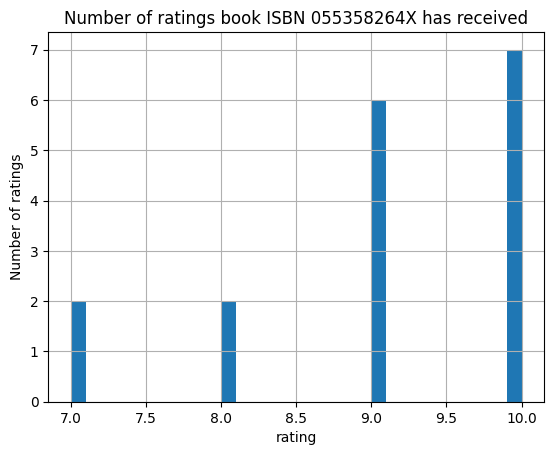

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

df_new.loc[df_new['ISBN'] == '0451191145']['bookRating'].hist(bins=30)
plt.xlabel('rating')
plt.ylabel('Number of ratings')
plt.title('Number of ratings book ISBN 055358264X has received')
plt.show();